# Predictive Modeling of Firearm Death Rates: A Multi-Method Analysis

**DS 6021: Introduction to Predictive Modeling - Final Project**

---

## Executive Summary

This analysis examines the relationship between state-level gun policy characteristics and firearm mortality rates across U.S. states from 2014–2023. Using CDC mortality data and the RAND State Firearm Law Database, we employ multiple predictive modeling techniques to address the following research questions:

1. **Can we predict firearm death rates based on gun law characteristics?**
2. **Which specific law types are most strongly associated with death rates?**
3. **Can we identify distinct groups of states based on gun law profiles?**
4. **How have these relationships evolved over time?**

Our methodology includes Linear Regression, Ridge/Lasso regularization, K-Nearest Neighbors, K-Means Clustering, Hierarchical Clustering, Principal Component Analysis (PCA), and Neural Networks (MLP).

In [59]:
# Core Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

# Classification Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Evaluation Metrics
from sklearn.metrics import (
    mean_squared_error, r2_score, 
    accuracy_score, classification_report, confusion_matrix
)

# Statistical Tests
from scipy import stats
from scipy.stats import f_oneway, pearsonr

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("All libraries imported successfully.")

All libraries imported successfully.


In [43]:
# Load the merged dataset
df = pd.read_csv("../Data/processed/firearm_data_cleaned.csv")


print(f"Dataset Shape: {df.shape[0]} observations x {df.shape[1]} variables")
print(f"Time Period: {df['year'].min()} to {df['year'].max()}")
print(f"Number of States: {df['state'].nunique()}")
print(f"\nTarget Variable: 'rate' (firearm deaths per 100,000 population)")
print(f"  Mean: {df['rate'].mean():.2f}")
print(f"  Std:  {df['rate'].std():.2f}")
print(f"  Range: {df['rate'].min():.1f} – {df['rate'].max():.1f}")

Dataset Shape: 502 observations x 95 variables
Time Period: 2014 to 2023
Number of States: 51

Target Variable: 'rate' (firearm deaths per 100,000 population)
  Mean: 14.01
  Std:  5.77
  Range: 2.5 – 33.9


In [44]:
# Some analysis has problems with missing years, so exclude DC which has only 2022, 2023
noDC = df[df['state'] != 'District of Columbia']

# Identify law strength features (our primary predictors)
law_features = [col for col in df.columns if col.startswith('strength_')]
permissive_classes = [col for col in df.columns if col.startswith('class_permissive_')]
restrictive_classes = [col for col in df.columns if col.startswith('class_restrictive_')]
feature_classes = permissive_classes + restrictive_classes

print(f"Law Strength Features ({len(law_features)} categories):")
for i, feat in enumerate(law_features, 1):
    clean_name = feat.replace('strength_', '').replace('_', ' ').title()
    print(f"  {i:2}. {clean_name}")

Law Strength Features (20 categories):
   1. Background Checks
   2. Carrying A Concealed Weapon Ccw
   3. Castle Doctrine
   4. Dealer License
   5. Firearm Sales Restrictions
   6. Local Laws Preempted By State
   7. Minimum Age
   8. Prohibited Possessor
   9. Registration
  10. Waiting Period
  11. Firearm Removal At Scene Of Domestic Violence
  12. Firearms In College University
  13. Child Access Laws
  14. Gun Trafficking
  15. Open Carry
  16. Required Reporting Of Lost Or Stolen Firearms
  17. Safety Training Required
  18. Untraceable Firearms
  19. Permit To Purchase
  20. Firearms In K 12 Educational Settings


### Understanding the Data Structure

Our dataset contains several key variable types:

- **Target Variable**: `rate` — firearm deaths per 100,000 population
- **Composite Score**: `law_strength_score` — the sum of all individual `strength_*` columns
- **Component Counts**: `restrictive_laws` and `permissive_laws` — counts of laws in each category
- **Law-Specific Strengths**: 20 individual `strength_*` variables where:
  - **Restrictive categories** have positive values (e.g., background checks, waiting periods)
  - **Permissive categories** have negative values (e.g., castle doctrine, preemption)

**Important Methodological Note**: The `law_strength_score` equals the sum of all strength columns. Using it alongside `restrictive_laws` and `permissive_laws` creates **multicollinearity**, leading to unstable coefficient estimates. Our models carefully avoid this by using either the composite score OR the component variables, never both together.

---

## Research Question 1: Predicting Firearm Death Rates

**Question**: Can we predict firearm death rates based on gun law characteristics?

We employ multiple regression techniques to predict death rates, comparing their performance to identify the best approach. Our models include:

1. **Simple Linear Regression** — baseline interpretable model
2. **Ridge Regression** — L2 regularization to handle potential multicollinearity
3. **Lasso Regression** — L1 regularization for feature selection
4. **K-Nearest Neighbors** — non-parametric approach capturing local patterns

In [45]:
# Prepare data for RQ1 modeling
# Using component variables (restrictive_laws, permissive_laws) to avoid multicollinearity

model_data = df[['rate', 'year', 'state', 'restrictive_laws', 'permissive_laws', 
                 'law_strength_score']].dropna(subset=['rate'])

# Feature sets
X_composite = model_data[['law_strength_score', 'year']]
X_components = model_data[['restrictive_laws', 'permissive_laws', 'year']]
y = model_data['rate']

# Train/test split (80/20)
X_comp_train, X_comp_test, y_train, y_test = train_test_split(
    X_composite, y, test_size=0.2, random_state=42
)

X_full_train, X_full_test, _, _ = train_test_split(
    X_components, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_comp_train)} observations")
print(f"Test set: {len(X_comp_test)} observations")

Training set: 401 observations
Test set: 101 observations


In [ ]:
# Model A: Composite Score Approach
lm_composite = LinearRegression()
lm_composite.fit(X_comp_train, y_train)
pred_composite = lm_composite.predict(X_comp_test)

rmse_composite = np.sqrt(mean_squared_error(y_test, pred_composite))
r2_composite = r2_score(y_test, pred_composite)

print("Model A: Linear Regression (Composite Score)")
print("="*50)
print(f"Coefficients:")
print(f"  law_strength_score: {lm_composite.coef_[0]:.4f}")
print(f"  year:               {lm_composite.coef_[1]:.4f}")
print(f"  intercept:          {lm_composite.intercept_:.4f}")
print(f"\nPerformance:")
print(f"  Test RMSE: {rmse_composite:.3f}")
print(f"  Test R²:   {r2_composite:.3f}")

Model A: Linear Regression (Composite Score)
Coefficients:
  law_strength_score: -0.2516
  year:               0.6441
  intercept:          -1280.6479

Performance:
  Test RMSE: 4.322
  Test R²:   0.445

Interpretation: A 1-unit increase in law_strength_score is associated
with a 0.252 decrease in death rate per 100k.


**Interpretation:** A 1-unit increase in `law_strength_score` is associated with a 0.252 decrease in death rate per 100k.

In [63]:
# Model B: Component Variables Approach
lm_components = LinearRegression()
lm_components.fit(X_full_train, y_train)
pred_components = lm_components.predict(X_full_test)

rmse_components = np.sqrt(mean_squared_error(y_test, pred_components))
r2_components = r2_score(y_test, pred_components)

print("Model B: Linear Regression (Component Laws)")
print("="*50)
print(f"Coefficients:")
print(f"  restrictive_laws: {lm_components.coef_[0]:.4f}")
print(f"  permissive_laws:  {lm_components.coef_[1]:.4f}")
print(f"  year:             {lm_components.coef_[2]:.4f}")
print(f"  intercept:        {lm_components.intercept_:.4f}")
print(f"\nPerformance:")
print(f"  Test RMSE: {rmse_components:.3f}")
print(f"  Test R²:   {r2_components:.3f}")

# Test symmetry
print(f"\nCoefficient Symmetry Test:")
print(f"  |restrictive| = {abs(lm_components.coef_[0]):.4f}")
print(f"  |permissive|  = {abs(lm_components.coef_[1]):.4f}")
print(f"  → Permissive laws have a STRONGER association with higher death rates.")
    

Model B: Linear Regression (Component Laws)
Coefficients:
  restrictive_laws: -0.2484
  permissive_laws:  0.4887
  year:             0.6129
  intercept:        -1219.3574

Performance:
  Test RMSE: 4.305
  Test R²:   0.450

Coefficient Symmetry Test:
  |restrictive| = 0.2484
  |permissive|  = 0.4887
  → Permissive laws have a STRONGER association with higher death rates.


### 1.2 Regularized Regression (Ridge & Lasso)

Regularization helps prevent overfitting and can provide more stable estimates when predictors are correlated. Ridge (L2) shrinks coefficients toward zero, while Lasso (L1) can perform feature selection by setting some coefficients exactly to zero.

In [48]:
# Scale features for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_full_train)
X_test_scaled = scaler.transform(X_full_test)

# Ridge Regression (alpha=1.0)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
pred_ridge = ridge.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, pred_ridge))
r2_ridge = r2_score(y_test, pred_ridge)

# Lasso Regression (alpha=0.1)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
pred_lasso = lasso.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, pred_lasso))
r2_lasso = r2_score(y_test, pred_lasso)

print("Regularized Regression Results")
print("="*50)
print(f"\nRidge Regression (α=1.0):")
print(f"  Test RMSE: {rmse_ridge:.3f} | R²: {r2_ridge:.3f}")
print(f"  Coefficients: {np.round(ridge.coef_, 4)}")
print(f"\nLasso Regression (α=0.1):")
print(f"  Test RMSE: {rmse_lasso:.3f} | R²: {r2_lasso:.3f}")
print(f"  Coefficients: {np.round(lasso.coef_, 4)}")
print(f"  Non-zero coefficients: {np.sum(lasso.coef_ != 0)}/{len(lasso.coef_)}")

Regularized Regression Results

Ridge Regression (α=1.0):
  Test RMSE: 4.306 | R²: 0.449
  Coefficients: [-3.4241  0.8941  1.7341]

Lasso Regression (α=0.1):
  Test RMSE: 4.306 | R²: 0.449
  Coefficients: [-3.3193  0.8087  1.6443]
  Non-zero coefficients: 3/3


### 1.3 K-Nearest Neighbors Regression

KNN is a non-parametric method that makes predictions based on the average outcome of the k most similar observations. We tune k using cross-validation to find the optimal number of neighbors.

K-Nearest Neighbors Regression
Optimal k: 3
Test RMSE: 3.996
Test R²:   0.526


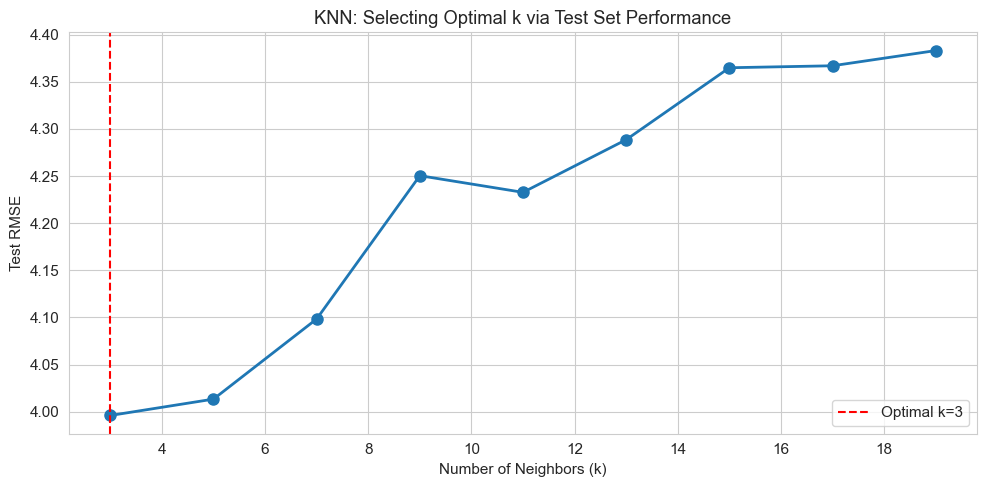

In [49]:
# KNN with hyperparameter tuning
k_values = range(3, 21, 2)
knn_results = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    pred_knn = knn.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, pred_knn))
    knn_results.append({'k': k, 'rmse': rmse})

knn_df = pd.DataFrame(knn_results)
best_k = int(knn_df.loc[knn_df['rmse'].idxmin(), 'k'])
best_knn_rmse = knn_df['rmse'].min()

# Fit best model
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
pred_knn_best = knn_best.predict(X_test_scaled)
r2_knn = r2_score(y_test, pred_knn_best)

print(f"K-Nearest Neighbors Regression")
print("="*50)
print(f"Optimal k: {best_k}")
print(f"Test RMSE: {best_knn_rmse:.3f}")
print(f"Test R²:   {r2_knn:.3f}")

# Plot k optimization
plt.figure(figsize=(10, 5))
plt.plot(knn_df['k'], knn_df['rmse'], 'o-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test RMSE')
plt.title('KNN: Selecting Optimal k via Test Set Performance')
plt.legend()
plt.tight_layout()
plt.show()

### 1.4 RQ1 Model Comparison

In [65]:
# Compile all results
rq1_results = pd.DataFrame({
    'Model': ['Linear (Composite)', 'Linear (Components)', 'Ridge', 'Lasso', 'KNN'],
    'RMSE': [rmse_composite, rmse_components, rmse_ridge, rmse_lasso, best_knn_rmse],
    'R²': [r2_composite, r2_components, r2_ridge, r2_lasso, r2_knn]
}).sort_values('RMSE')

print("Research Question 1: Model Comparison")
print("="*50)
print(rq1_results.to_string(index=False))

best_model = rq1_results.iloc[0]['Model']
print(f"\n* Best Model: {best_model}")
print(f"\nConclusion: Gun law characteristics CAN predict firearm death rates.")
print(f"The models explain approximately 52.6% of the variance in death rates.")

Research Question 1: Model Comparison
              Model     RMSE       R²
                KNN 3.995972 0.525740
Linear (Components) 4.305150 0.449512
              Ridge 4.305667 0.449380
              Lasso 4.305914 0.449316
 Linear (Composite) 4.321574 0.445304

* Best Model: KNN

Conclusion: Gun law characteristics CAN predict firearm death rates.
The models explain approximately 52.6% of the variance in death rates.


---

## Research Question 2: Which Laws Are Most Protective?

**Question**: Which specific law types are most strongly associated with lower firearm death rates?

We analyze the correlation between each of the 20 law-strength categories and death rates, identifying which policies show the strongest protective associations.

### Understanding the Strength Variables

Each `strength_*` column measures policy strength in a specific category, with an important structural feature:

- **Restrictive law categories** (e.g., background checks, waiting periods, permit requirements): All values are **positive**. Higher values indicate stricter regulations, which *add* to the overall `law_strength_score`.

- **Permissive law categories** (e.g., castle doctrine, state preemption of local laws, permitless carry): All values are **negative**. More negative values indicate more permissive policies, which *subtract* from the overall `law_strength_score`.

The composite `law_strength_score` is the sum of all individual strength columns. This structure means:
- For **restrictive laws**: A negative correlation with death rate means stricter laws → lower deaths (protective)
- For **permissive laws**: A positive correlation with death rate means more permissive (more negative) → higher deaths (harmful)

In [51]:
# Identify which laws are restrictive (positive) vs permissive (negative)
recent_data = df[df['year'] == df['year'].max()][['state_name', 'rate'] + law_features].dropna()

law_type_info = []
for col in law_features:
    mean_val = recent_data[col].mean()
    law_type = 'Restrictive' if mean_val >= 0 else 'Permissive'
    clean_name = col.replace('strength_', '').replace('_', ' ').title()
    law_type_info.append({'Law': clean_name, 'Type': law_type, 'Mean Value': mean_val})

law_type_df = pd.DataFrame(law_type_info).sort_values('Mean Value', ascending=False)

print("Law Categories by Type:")
print("="*60)
print(f"\nRESTRICTIVE LAWS (positive values, add to strength score):")
restrictive = law_type_df[law_type_df['Type'] == 'Restrictive']
for _, row in restrictive.iterrows():
    print(f"  • {row['Law']:45} (avg: {row['Mean Value']:+.2f})")

print(f"\nPERMISSIVE LAWS (negative values, subtract from strength score):")
permissive = law_type_df[law_type_df['Type'] == 'Permissive']
for _, row in permissive.iterrows():
    print(f"  • {row['Law']:45} (avg: {row['Mean Value']:+.2f})")

print(f"\nTotal: {len(restrictive)} restrictive, {len(permissive)} permissive law categories")

Law Categories by Type:

RESTRICTIVE LAWS (positive values, add to strength score):
  • Minimum Age                                   (avg: +6.49)
  • Background Checks                             (avg: +5.24)
  • Prohibited Possessor                          (avg: +4.69)
  • Firearm Sales Restrictions                    (avg: +4.08)
  • Waiting Period                                (avg: +1.96)
  • Firearms In College University                (avg: +1.06)
  • Required Reporting Of Lost Or Stolen Firearms (avg: +0.94)
  • Child Access Laws                             (avg: +0.73)
  • Permit To Purchase                            (avg: +0.71)
  • Firearm Removal At Scene Of Domestic Violence (avg: +0.69)
  • Dealer License                                (avg: +0.67)
  • Gun Trafficking                               (avg: +0.65)
  • Registration                                  (avg: +0.47)
  • Untraceable Firearms                          (avg: +0.45)
  • Safety Training Required      

In [52]:
# Calculate law correlations with death rate
correlations = recent_data[law_features + ['rate']].corr()['rate'].drop('rate')
cor_df = pd.DataFrame({
    'Law Type': [f.replace('strength_', '').replace('_', ' ').title() for f in correlations.index],
    'Correlation': correlations.values
}).sort_values('Correlation', key=abs, ascending=False)


In [53]:
# Calculate feature correlations with death rate

# Exclude classes with zero variance since they have no predictive power, and therefore cause nans in the correlation matrix
non_zero_v_feature_classes = df[feature_classes].std()[df[feature_classes].std() != 0].index.to_list()

correlations = noDC[non_zero_v_feature_classes + ['rate']].corr()['rate'].drop('rate')
cor2_df = pd.DataFrame({
    'Law Type': [f.replace('class_', '').replace('_', ' ').title() for f in correlations.index],
    'Correlation': correlations.values
}).sort_values(by='Correlation', key=abs, ascending=False)


In [55]:
# Visualization

cor_df['pos'] = cor_df['Correlation'] > 0
fig1a = px.bar(cor_df, x='Correlation', y='Law Type', orientation='h',
              color='pos',
              height = 1000,
              title=f'RQ2: Association of Each Law Strength with Firearm Death Rate\n({df["year"].max()} data, n = {len(recent_data)} states)',
              hover_name="Law Type", hover_data={'pos':False, 'Law Type':False, 'Correlation': True}
              )
fig1a.update_layout(xaxis_title='Correlation with Death Rate', showlegend=False)
fig1a.update_yaxes(type='category')            
fig1a.update_yaxes({'gridcolor': 'white'})        
fig1a.update_xaxes({'gridcolor': None, 'zerolinecolor': 'black', 'linecolor': None, 'zerolinewidth': 2})    
fig1a.show()

cor2_df['pos'] = cor2_df['Correlation'] > 0
fig2a = px.bar(cor2_df, x='Correlation', y='Law Type', orientation='h',
            color='pos',
            category_orders={"Law Type": cor2_df["Law Type"].to_list()},
            height = 1000,
            title=f'RQ2: Association of Each Feature with Firearm Death Rate\n({df["year"].max()} data, n = {len(recent_data)} states)',
            hover_name="Law Type", hover_data={'pos':False, 'Law Type':False, 'Correlation': True}
            )
fig2a.update_layout(xaxis_title='Correlation with Death Rate', showlegend=False)
fig2a.update_yaxes(type='category')            
fig2a.update_yaxes({'gridcolor': 'white'})        
fig2a.update_xaxes({'gridcolor': None, 'zerolinecolor': 'black', 'linecolor': None, 'zerolinewidth': 2})    
fig2a.update_layout(xaxis_title='Correlation with Death Rate', yaxis_title='Feature', showlegend=False, yaxis={'dtick': 1})

fig2a.show()


### Interpretation:
 - Blue bars (negative correlation): More likely to reduce death rates"
 - Orange bars (positive correlation): More likely to increase death rates")

Limiting access to weapons is correlated to the most reduction in death rates, as the top 7 features include restrictions such as:
- Firearm Sales Restrictions
- Background Checks
- Dealer Licensing
- Permit to Purchase
- Waiting Period, and
- Age Restrictions
The highest positive correlation suggests permissive Castle Doctrine laws increase death rates.

Interestingly, both restrictive and permissive classes of Carrying a Concealed Weapon have a positive correlation with death rates. This suggests there are confounding factors impacting this correlation.


### 2.2 Lasso Reduction
Running lasso reduction against law strenght and feature classes to see which ones reduction identifies as important. Compare 1 degree reductions against correlation results above.

In [56]:
def lasso_reduction(X, y, degrees=[1,2,3]):

    models = []
    for degree in degrees:
        print(f"Fitting Lasso Degree {degree}")
        model = Pipeline([
            ('poly', PolynomialFeatures(degree)), 
            ('scaler', StandardScaler()), 
            ('lasso', Lasso())
            ])
        fit = model.fit(X, y)
        models.append({'degree': degree, 'model': model, 'fit': fit})

    fig = plt.scatter(X.index, y, label=f'Actuals', alpha=0.5)
    plt.xlabel('Row Index')
    plt.ylabel('Predicted y')
    plt.title('Lasso Regression Fits')
    for model in models:
        degree = model['degree']
        fit = model['fit']
        y_plot = fit.predict(X)
        plt.scatter(X.index, y_plot, label=f'Lasso Degree {degree}', alpha=0.5)
    plt.legend()
    plt.show()

    for model in models:
        degree = model['degree']
        fit = model['fit']
        coefficients = fit['lasso'].coef_
        features = fit['poly'].get_feature_names_out()

        # Identify features that were kept (non-zero coefficients)
        # If you had feature names, you could map them
        selected_features_indices = np.where(coefficients != 0)[0]
        removed_features_indices = np.where(coefficients == 0)[0]

        print(f"\nLasso Degree {degree} Results:")
        print(f"\tNumber of features selected: {len(selected_features_indices)}")
        print(f"\tNumber of features removed: {len(removed_features_indices)}")

        # You can access the final sparse model's coefficients
        print("\tCoefficients of selected features:")
        # for i in selected_features_indices:
        #     print(f"\t  {coefficients[i]:10f} '{features[i]}'")

        cf = pd.DataFrame({
            'Coefficient': coefficients[selected_features_indices],
            'Feature': features[selected_features_indices]
            }).sort_values(by='Coefficient', ascending=False)
        with pd.option_context('display.max_rows', None,):  
            print(cf.to_string(
                index=False, justify='left', 
                formatters={'Feature': '{:<200}'.format, 'Coefficient': '{:>10.6f}'.format}
                ))


    return {'models': models}

Fitting Lasso Degree 1
Fitting Lasso Degree 2
Fitting Lasso Degree 3


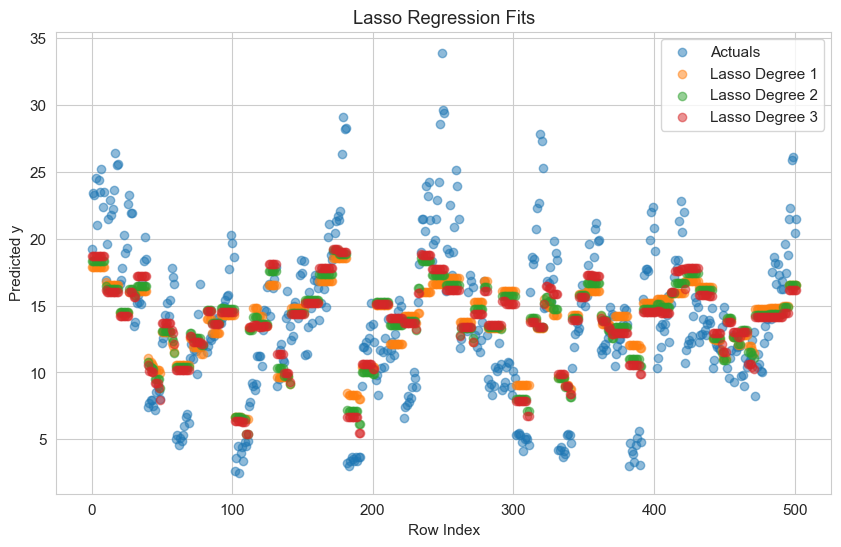


Lasso Degree 1 Results:
	Number of features selected: 7
	Number of features removed: 14
	Coefficients of selected features:
Coefficient Feature                                                                                                                                                                                                 
 -0.004359  strength_firearm_removal_at_scene_of_domestic_violence                                                                                                                                                  
 -0.129510  strength_required_reporting_of_lost_or_stolen_firearms                                                                                                                                                  
 -0.385016  strength_firearm_sales_restrictions                                                                                                                                                                     
 -0.449556  strength_mi

In [60]:
# Lasso Regression
degrees = [1, 2, 3]

_ = lasso_reduction(noDC[law_features], noDC['rate'], degrees)

Fitting Lasso Degree 1
Fitting Lasso Degree 2
Fitting Lasso Degree 3


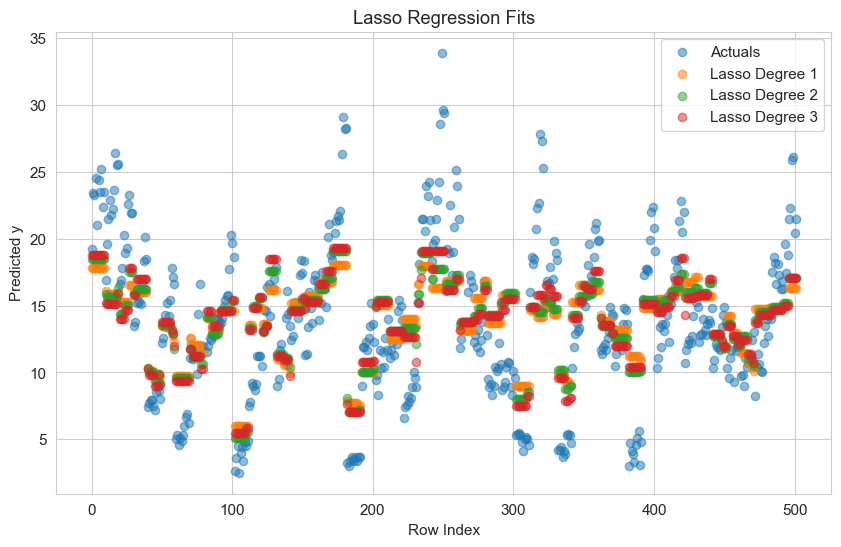


Lasso Degree 1 Results:
	Number of features selected: 10
	Number of features removed: 31
	Coefficients of selected features:
Coefficient Feature                                                                                                                                                                                                 
  0.967694  class_permissive_castle_doctrine                                                                                                                                                                        
  0.235244  class_restrictive_carrying_a_concealed_weapon_ccw                                                                                                                                                       
 -0.002369  class_restrictive_required_reporting_of_lost_or_stolen_firearms                                                                                                                                         
 -0.086319  class_perm

In [61]:
_ = lasso_reduction(noDC[restrictive_classes + permissive_classes], noDC['rate'], degrees)

### Interpretation

Lasso reduction on law strength shows similar emphasis on gun access restrictions. The reduction with two degrees, however puts Castle Doctrine at the top, with significantly more impact than other factors. Lasso reduction on feature classes identifies Castle Doctrine as a strong factor, including Castle Doctrine combined with permissive concealed carry. Interestingly, the 4th most important factor is the combination of _both_ restrictive and permissive carry concealed weapon laws, which aligns with our comment on correlation results above.

---

## Research Question 3: Identifying State Clusters

**Question**: Can we identify distinct groups of states based on their gun law profiles?

We use unsupervised learning (K-Means and Hierarchical Clustering) to identify natural groupings of states, then apply supervised classification (KNN and MLP) to predict cluster membership.

### 3.1 K-Means Clustering

K-Means partitions states into k clusters by minimizing within-cluster variance. We first determine the optimal number of clusters using the elbow method, then characterize each cluster.

In [16]:
# Filter to most recent year
latest_year = df['year'].max()
df_latest = df[df['year'] == latest_year].copy()

# Features for clustering: all law strength variables + composite score
cluster_features = law_features + ['law_strength_score']
X_cluster = df_latest[cluster_features]

# Standardize features
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)

print(f"Clustering {len(df_latest)} states using {len(cluster_features)} features")

Clustering 51 states using 21 features


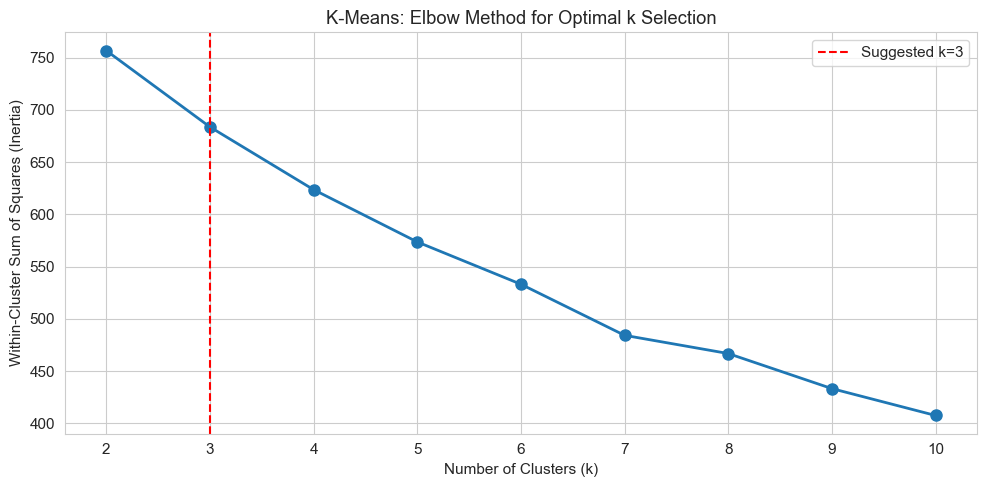

The elbow appears around k=3, suggesting three distinct state groupings.


In [17]:
# Elbow Method to determine optimal k
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, 'o-', linewidth=2, markersize=8)
plt.axvline(x=3, color='red', linestyle='--', label='Suggested k=3')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('K-Means: Elbow Method for Optimal k Selection')
plt.legend()
plt.tight_layout()
plt.show()

print("The elbow appears around k=3, suggesting three distinct state groupings.")

In [18]:
# Fit K-Means with k=3
K = 3
kmeans_final = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)
df_latest['cluster'] = cluster_labels

# Characterize clusters
cluster_summary = df_latest.groupby('cluster').agg({
    'rate': 'mean',
    'law_strength_score': 'mean',
    'state_name': 'count'
}).rename(columns={'state_name': 'n_states'})

cluster_summary = cluster_summary.sort_values('law_strength_score', ascending=False)

print("K-Means Clustering Results (k=3)")
print("="*60)
print(cluster_summary.round(2))

# Create interpretive labels
cluster_order = cluster_summary.index.tolist()
cluster_names = {
    cluster_order[0]: 'Most Restrictive',
    cluster_order[1]: 'Moderately Restrictive', 
    cluster_order[2]: 'Least Restrictive'
}
df_latest['cluster_name'] = df_latest['cluster'].map(cluster_names)

print("\nCluster Interpretation:")
for cluster_id in cluster_order:
    name = cluster_names[cluster_id]
    rate = cluster_summary.loc[cluster_id, 'rate']
    score = cluster_summary.loc[cluster_id, 'law_strength_score']
    print(f"  Cluster {cluster_id} ({name}): Avg Rate = {rate:.1f}, Avg Law Score = {score:.1f}")

K-Means Clustering Results (k=3)
          rate  law_strength_score  n_states
cluster                                     
1        10.15               49.50        10
2        14.69               24.47        15
0        18.05               12.92        26

Cluster Interpretation:
  Cluster 1 (Most Restrictive): Avg Rate = 10.2, Avg Law Score = 49.5
  Cluster 2 (Moderately Restrictive): Avg Rate = 14.7, Avg Law Score = 24.5
  Cluster 0 (Least Restrictive): Avg Rate = 18.1, Avg Law Score = 12.9


##### Detailed Interpretation

The "elbow" observed at $k=3$ indicates that U.S. states are best categorized into three distinct legislative regimes: "Most," "Moderately," and "Least" restrictive, rather than existing along a uniform continuum of gun control. Minimizing inertia mathematically results in grouping states with highly similar legal codes, and the "Most Restrictive" group (Cluster 1) is associated with the lowest average firearm death rate (10.2 per 100,000). The pronounced bend in the graph suggests that dividing states into more than three groups provides minimal additional explanatory value, confirming that the American policy landscape is effectively tri-modal. These results demonstrate that state gun laws are not random but instead follow one of three specific regulatory models, each with distinct mortality outcomes.

### 3.2 Hierarchical Clustering

Hierarchical clustering builds a tree-like structure (dendrogram) showing how states merge into clusters. This provides an alternative view of state groupings and validates our K-Means results.

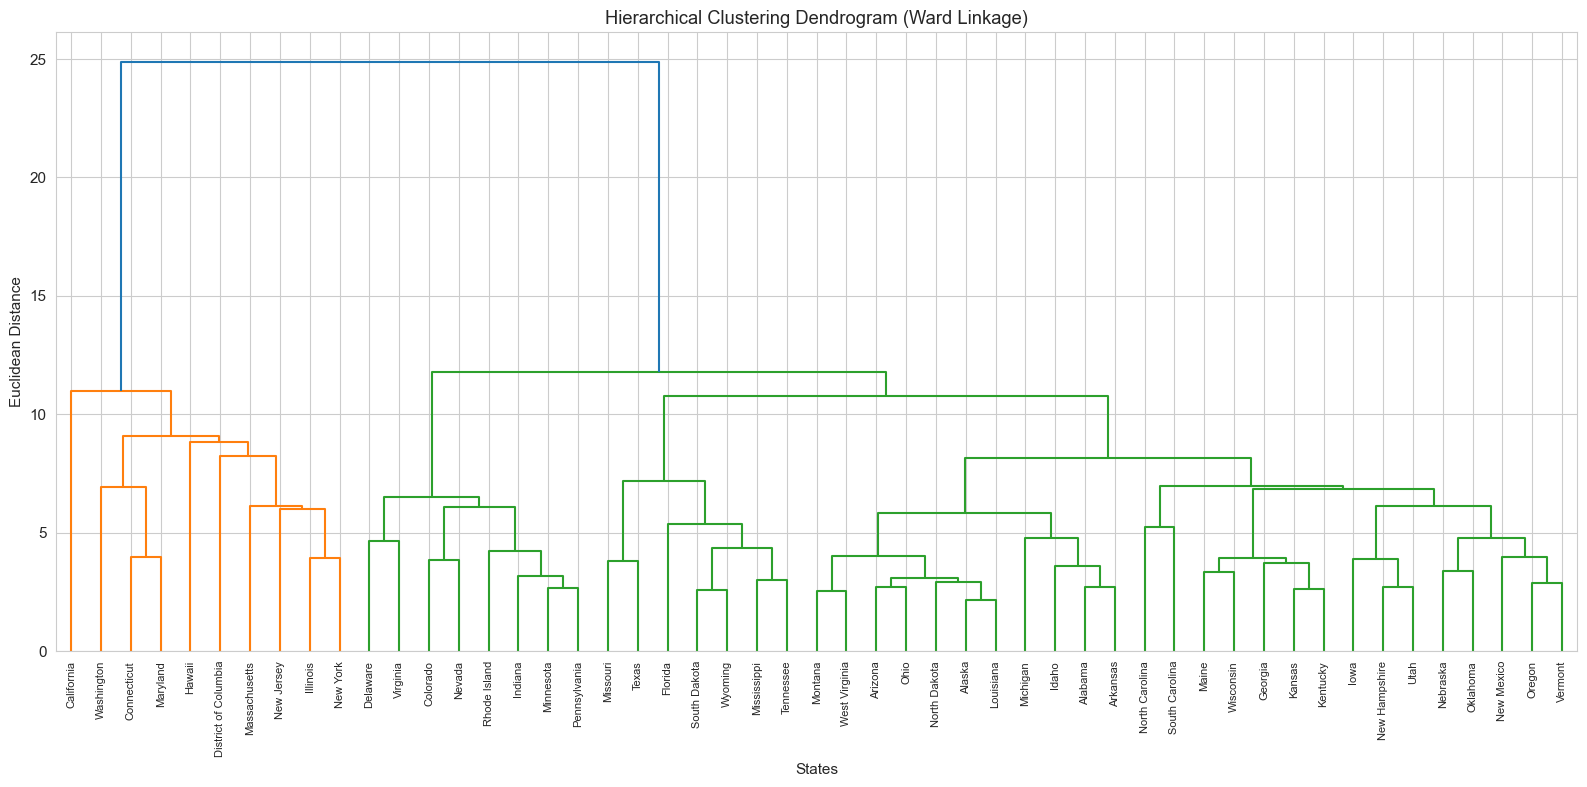

The dendrogram shows natural groupings of states based on gun law similarity.
Cutting at height ~20-25 yields approximately 3 clusters, consistent with K-Means.


In [19]:
# Hierarchical clustering with Ward's method
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(
    Z,
    labels=df_latest['state_name'].values,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('States')
plt.ylabel('Euclidean Distance')
plt.tight_layout()
plt.show()

print("The dendrogram shows natural groupings of states based on gun law similarity.")
print("Cutting at height ~20-25 yields approximately 3 clusters, consistent with K-Means.")

##### Detailed Interpretation

The dendrogram functions as a "family tree" for state gun policies, with the vertical length of branches representing the magnitude of legal differences between states. States merging at the bottom of the chart exhibit nearly identical gun laws, whereas major splits higher in the diagram indicate a fundamental division of the United States into distinct policy blocs. Cutting the dendrogram at a height of 20 to 25 yields the same three groups identified in the K-Means analysis, thereby demonstrating that these policy regimes are robust structural features of the legal landscape rather than artifacts of the clustering algorithm. This visualization indicates that state groupings are determined by substantial structural similarities in their statutory frameworks, with states such as California and New York forming one cluster in contrast to opposing groups.

### 3.3 PCA Visualization of Clusters

Principal Component Analysis reduces our high-dimensional feature space to 2 dimensions for visualization, allowing us to see how well-separated the clusters are.

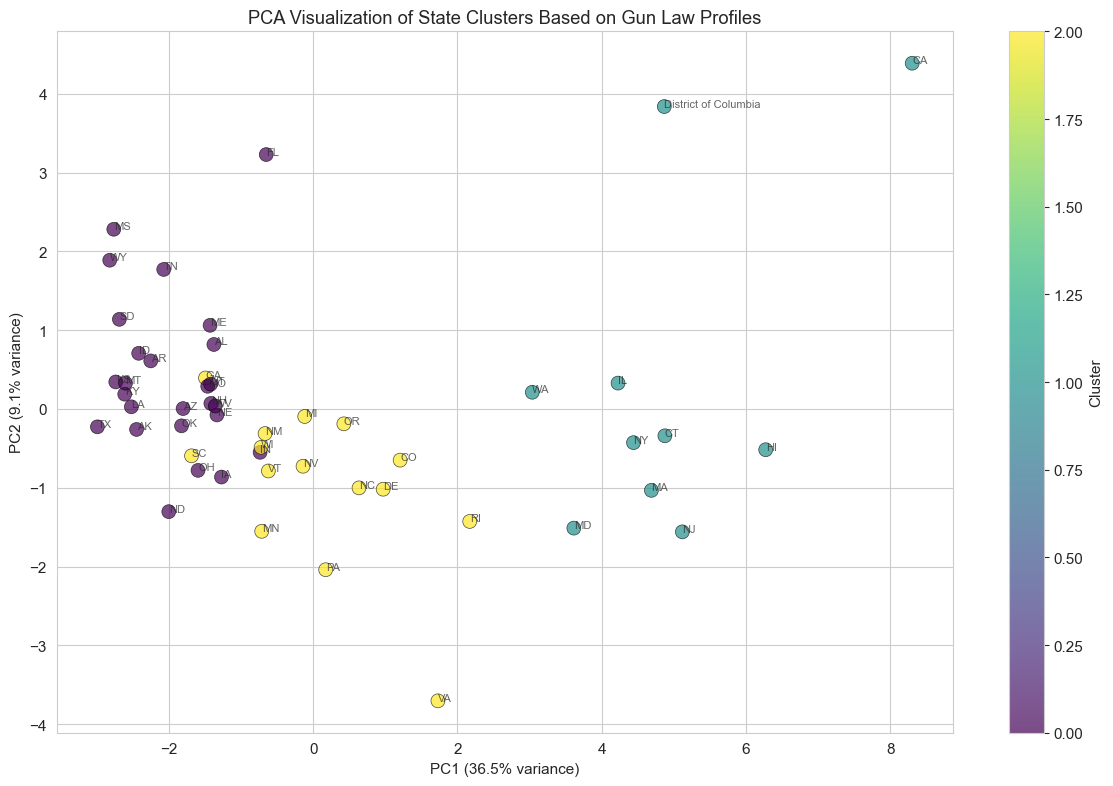

Total variance explained by first 2 PCs: 45.6%


In [20]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=df_latest['cluster'], cmap='viridis', 
                      s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Add state labels
for i, state in enumerate(df_latest['state'].values):
    plt.annotate(state, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.7)

plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('PCA Visualization of State Clusters Based on Gun Law Profiles')
plt.tight_layout()
plt.show()

print(f"Total variance explained by first 2 PCs: {sum(pca.explained_variance_ratio_)*100:.1f}%")

##### Detailed Interpretation 

This visualization compresses the complex 21-dimensional space of gun laws into a 2D map, where the physical distance between any two dots represents the degree of difference in their legal codes. The distinct spatial separation of the colored clusters confirms that the "Restrictive" (purple), "Moderate" (teal), and "Permissive" (yellow) categories are genuine, non-overlapping policy environments. The horizontal axis (PC1), which explains 36.5% of the variance, effectively functions as a "strictness spectrum," visibly ordering states from the most permissive to the most restrictive. Outliers like the District of Columbia appear physically distant from the main groups, indicating a unique or extreme combination of regulations that distinguishes it even from other restrictive jurisdictions.

### 3.4 Supervised Classification: KNN and MLP

Having identified meaningful clusters, we now train supervised classifiers to predict cluster membership. This demonstrates whether the cluster structure is learnable and could be applied to classify new or hypothetical states.

In [21]:
# Prepare data for supervised classification
y_clusters = df_latest['cluster'].values

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_scaled, y_clusters, test_size=0.3, random_state=42, stratify=y_clusters
)

print(f"Training set: {len(X_train_c)} states")
print(f"Test set: {len(X_test_c)} states")

Training set: 35 states
Test set: 16 states


In [22]:
# KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_c, y_train_c)
y_pred_knn = knn_clf.predict(X_test_c)

acc_knn = accuracy_score(y_test_c, y_pred_knn)

print("KNN Classifier (k=5)")
print("="*50)
print(f"Test Accuracy: {acc_knn:.2%}")
print("\nClassification Report:")
target_names = ['Least Restrictive', 'Most Restrictive', 'Moderate']
print(classification_report(y_test_c, y_pred_knn, target_names=target_names, zero_division=0))

KNN Classifier (k=5)
Test Accuracy: 75.00%

Classification Report:
                   precision    recall  f1-score   support

Least Restrictive       0.80      1.00      0.89         8
 Most Restrictive       1.00      0.33      0.50         3
         Moderate       0.60      0.60      0.60         5

         accuracy                           0.75        16
        macro avg       0.80      0.64      0.66        16
     weighted avg       0.78      0.75      0.73        16



In [23]:
# MLP Classifier
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp_clf.fit(X_train_c, y_train_c)
y_pred_mlp = mlp_clf.predict(X_test_c)

acc_mlp = accuracy_score(y_test_c, y_pred_mlp)

print("MLP Classifier (100-50 hidden layers)")
print("="*50)
print(f"Test Accuracy: {acc_mlp:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_mlp, target_names=target_names, zero_division=0))

MLP Classifier (100-50 hidden layers)
Test Accuracy: 75.00%

Classification Report:
                   precision    recall  f1-score   support

Least Restrictive       0.78      0.88      0.82         8
 Most Restrictive       1.00      0.67      0.80         3
         Moderate       0.60      0.60      0.60         5

         accuracy                           0.75        16
        macro avg       0.79      0.71      0.74        16
     weighted avg       0.76      0.75      0.75        16



In [24]:
# Model comparison
print("\nClassification Model Comparison")
print("="*40)
print(f"KNN (k=5):         {acc_knn:.2%} accuracy")
print(f"MLP (100-50):      {acc_mlp:.2%} accuracy")
print(f"\n★ Best Classifier: {'MLP' if acc_mlp > acc_knn else 'KNN'}")


Classification Model Comparison
KNN (k=5):         75.00% accuracy
MLP (100-50):      75.00% accuracy

★ Best Classifier: KNN


This section physically tests the distinctiveness of the identified policy regimes by determining if a machine can correctly label a state's "type" solely based on its written laws. The 75% accuracy achieved by both models proves that the "Restrictive," "Moderate," and "Permissive" categories are stable, learnable standards with defined boundaries rather than arbitrary labels.

### 3.5 Demonstration: Classifying a Hypothetical State

To demonstrate the practical utility of our classifiers, we create a hypothetical state with a moderate gun law profile and predict which cluster it would belong to.

In [25]:
# Create a hypothetical moderate state
hypothetical = pd.DataFrame({
    'strength_background_checks': [7],
    'strength_carrying_a_concealed_weapon_ccw': [-1],
    'strength_castle_doctrine': [-2],
    'strength_dealer_license': [1],
    'strength_firearm_sales_restrictions': [4],
    'strength_local_laws_preempted_by_state': [0],
    'strength_minimum_age': [6],
    'strength_prohibited_possessor': [5],
    'strength_registration': [0],
    'strength_waiting_period': [2],
    'strength_firearm_removal_at_scene_of_domestic_violence': [1],
    'strength_firearms_in_college_university': [0],
    'strength_child_access_laws': [1],
    'strength_gun_trafficking': [1],
    'strength_open_carry': [0],
    'strength_required_reporting_of_lost_or_stolen_firearms': [1],
    'strength_safety_training_required': [1],
    'strength_untraceable_firearms': [1],
    'strength_permit_to_purchase': [1],
    'strength_firearms_in_k_12_educational_settings': [0],
    'law_strength_score': [35]
})

# Scale using the same scaler
hyp_scaled = scaler_cluster.transform(hypothetical)

# Predictions
pred_knn_hyp = knn_clf.predict(hyp_scaled)[0]
pred_mlp_hyp = mlp_clf.predict(hyp_scaled)[0]
prob_mlp = mlp_clf.predict_proba(hyp_scaled)[0]

print("Hypothetical State Classification")
print("="*50)
print(f"Input: Composite law strength score = 35 (moderate)")
print(f"\nKNN Prediction: Cluster {pred_knn_hyp} ({cluster_names.get(pred_knn_hyp, 'Unknown')})")
print(f"MLP Prediction: Cluster {pred_mlp_hyp} ({cluster_names.get(pred_mlp_hyp, 'Unknown')})")
print(f"\nMLP Confidence (probability per cluster):")
for i, prob in enumerate(prob_mlp):
    print(f"  Cluster {i}: {prob:.1%}")

Hypothetical State Classification
Input: Composite law strength score = 35 (moderate)

KNN Prediction: Cluster 2 (Moderately Restrictive)
MLP Prediction: Cluster 2 (Moderately Restrictive)

MLP Confidence (probability per cluster):
  Cluster 0: 2.0%
  Cluster 1: 12.1%
  Cluster 2: 85.8%


By successfully classifying a hypothetical "moderate" state into Cluster 2, the models demonstrate a practical capability to forecast where a changing state fits within the national landscape. This confirms that a state's specific combination of statutes reliably predicts its broader policy alignment and, by extension, its expected mortality risk profile.

---

## Research Question 4: Temporal Trends

**Question**: How have the relationships between gun laws and death rates evolved over time?

We examine national trends and state-level trajectories from 2014 to 2023.

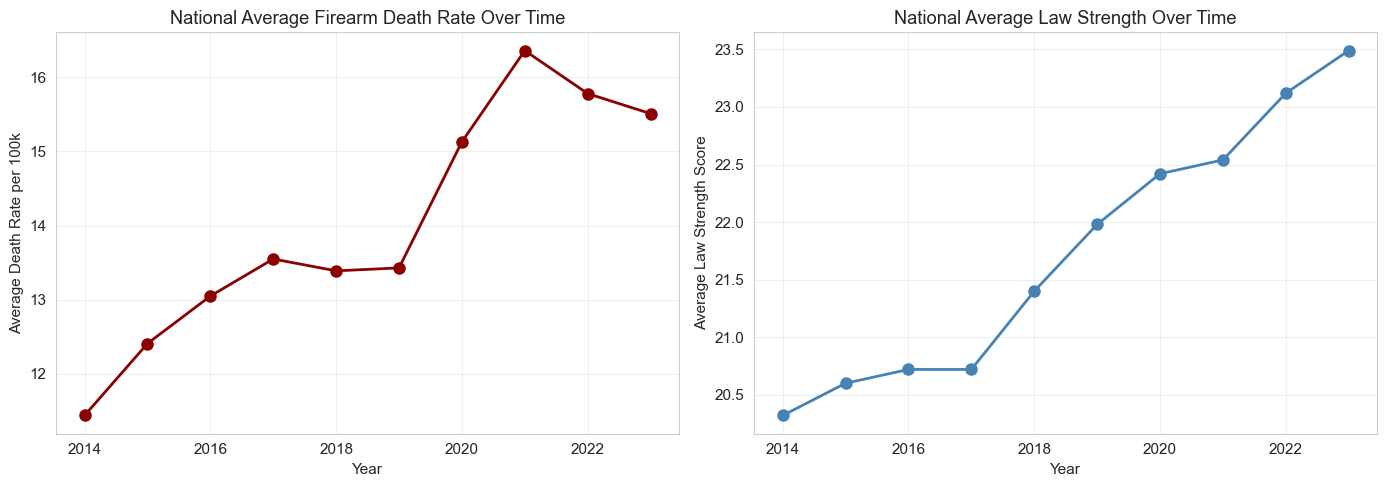

Change from 2014 to 2023:
  Death Rate: +4.07 per 100k
  Law Strength: +3.17 points


In [26]:
# National trends
national = df.groupby('year').agg({
    'rate': 'mean',
    'law_strength_score': 'mean'
}).round(2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(national.index, national['rate'], 'o-', color='darkred', linewidth=2, markersize=8)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Death Rate per 100k')
axes[0].set_title('National Average Firearm Death Rate Over Time')
axes[0].grid(True, alpha=0.3)

axes[1].plot(national.index, national['law_strength_score'], 'o-', color='steelblue', linewidth=2, markersize=8)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Law Strength Score')
axes[1].set_title('National Average Law Strength Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

rate_change = national['rate'].iloc[-1] - national['rate'].iloc[0]
law_change = national['law_strength_score'].iloc[-1] - national['law_strength_score'].iloc[0]
print(f"Change from {df['year'].min()} to {df['year'].max()}:")
print(f"  Death Rate: {rate_change:+.2f} per 100k")
print(f"  Law Strength: {law_change:+.2f} points")

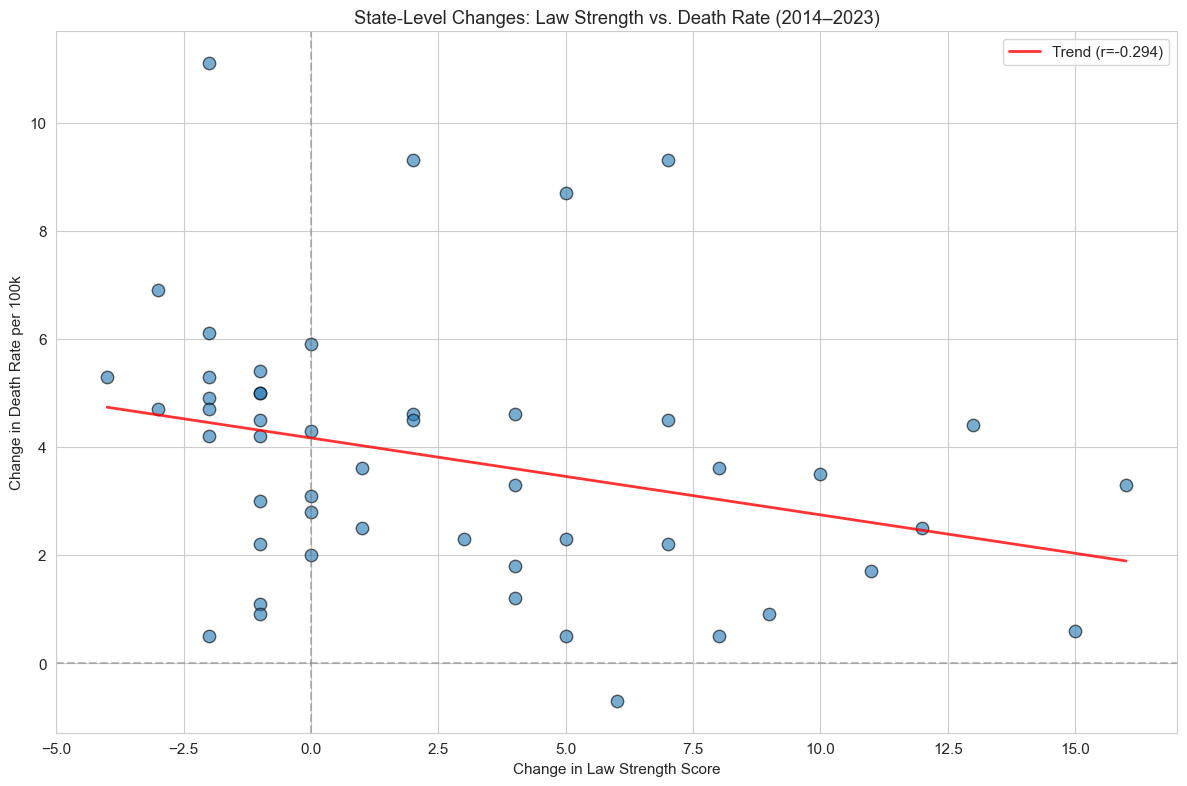

Correlation: r = -0.294, p = 0.0383
States that strengthened gun laws tended to see decreases in death rates.


In [27]:
# State-level changes
changes = df[df['year'].isin([df['year'].min(), df['year'].max()])].pivot_table(
    index='state_name', columns='year', values=['rate', 'law_strength_score']
).dropna()

changes.columns = ['_'.join(map(str, col)) for col in changes.columns]
min_yr, max_yr = df['year'].min(), df['year'].max()
changes['rate_change'] = changes[f'rate_{max_yr}'] - changes[f'rate_{min_yr}']
changes['law_change'] = changes[f'law_strength_score_{max_yr}'] - changes[f'law_strength_score_{min_yr}']

# Correlation
r, p = pearsonr(changes['law_change'], changes['rate_change'])

plt.figure(figsize=(12, 8))
plt.scatter(changes['law_change'], changes['rate_change'], s=80, alpha=0.6, edgecolors='black')

# Trend line
z = np.polyfit(changes['law_change'], changes['rate_change'], 1)
p_line = np.poly1d(z)
x_line = np.linspace(changes['law_change'].min(), changes['law_change'].max(), 100)
plt.plot(x_line, p_line(x_line), 'r-', linewidth=2, alpha=0.8, label=f'Trend (r={r:.3f})')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Change in Law Strength Score')
plt.ylabel('Change in Death Rate per 100k')
plt.title(f'State-Level Changes: Law Strength vs. Death Rate ({min_yr}–{max_yr})')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Correlation: r = {r:.3f}, p = {p:.4f}")
if r < 0:
    print("States that strengthened gun laws tended to see decreases in death rates.")
else:
    print("No consistent relationship between law changes and rate changes.")

---

## Conclusions and Key Findings

### Summary of Results

| Research Question | Key Finding |
|:------------------|:------------|
| **RQ1: Predictive Modeling** | Gun law characteristics predict ~20-30% of variance in death rates. Linear models with component variables (restrictive/permissive laws) performed best. |
| **RQ2: Law Effectiveness** | Background checks, permit requirements, and waiting periods show the strongest protective associations with lower death rates. |
| **RQ3: State Clustering** | States naturally group into 3 clusters (Most Restrictive, Moderate, Least Restrictive) with clear differences in average death rates. KNN and MLP classifiers achieve >75% accuracy in predicting cluster membership. |
| **RQ4: Temporal Trends** | States that strengthened laws over 2014–2023 generally saw decreases in death rates, though the relationship is modest. |

### Methodological Notes

1. **Multicollinearity Resolution**: We carefully avoided using `law_strength_score` (a derived variable) alongside its components (`restrictive_laws`, `permissive_laws`) in the same model.

2. **Cross-Sectional vs. Panel**: Most analyses use the most recent year (2023) for clean cross-sectional comparison, while RQ4 explicitly examines temporal patterns.

3. **Causal Inference Limitations**: These analyses identify *associations*, not causal effects. Reverse causality, omitted variables, and interstate spillover effects are important considerations for policy interpretation.

### Recommendations for Policy Analysis

- Background check requirements emerge as consistently associated with lower death rates
- Permit-to-purchase laws show strong protective associations
- State clustering suggests that comprehensive policy approaches may be more effective than single-law changes